Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

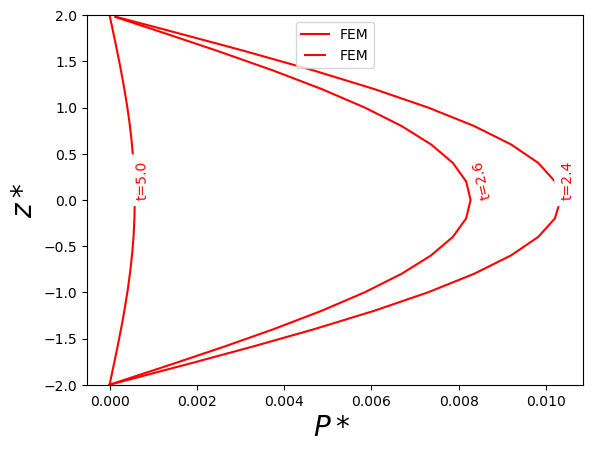

In [5]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt 
from matplotlib.legend_handler import HandlerLine2D# Matplotlib para gráficos
import math
import scipy
from cProfile import label
from label_lines import *

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
T = 10            # final time
num_steps = 50     # number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
nx = ny = 20
mesh = RectangleMesh(Point(-2, -2), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Expression('10',
                 degree=2, a=5)
u_n = interpolate(u_0, V)  # Interpola u_D en el espacio de funciones V
u_nn = interpolate(u_0, V) 
u_nnn = interpolate(u_0, V) 
# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test

# Formulación del problema variacional
#pconst=[3./2,-2,1./2,0.0] #bdf2
#pconst = [0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3] #bdf2 op
#pconst= [11/6,-3,3/2,-1/3] #bdf 3
pconst=[1,-1,0,0] #bdf1

du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn
f = Constant(0)


F = du_t*v*dx  - dt*dot(grad(u), grad(v))*dx +
a, L = lhs(F), rhs(F)

# Create VTK file for saving solution
vtkfile_u = XDMFFile("results/u_fem.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False

# Time-stepping
u_ = Function(V)
t = 0
u_t=[]
n_t = 0
ig, ax = plt.subplots()
for n in range(num_steps):

    # Update current time
    t += dt
    # Compute solution
    solve(a == L, u_, bc)
    # Update previous solution
    u_n.assign(u_)
    u_.rename("u_a", "u_a");vtkfile_u.write(u_, t)
    if near(t,T/2,dt/2) or near(t,T/4,dt/2) :
        z_=-2
        
        for k in range(200):
            pdot=u_(0.0,z_)
            if k ==0:
                results=np.array([[pdot,z_]])
            else:
                results =np.append(results,np.array([[pdot,z_]]),axis=0)
            z_+= 2*1/100
        line1, =ax.plot(results[:, 0], results[:, 1], "-",color='red',label="FEM")
        plt.xlabel("$P*$ ",fontsize=20)
        plt.ylabel("$z*$",fontsize=20)

        lines = plt.gca().get_lines()
        l1=lines[-1]
        labelLine(l1,0.0,label=f't={round(t,2)}',ha='left',va='bottom',align = True)
        if near(t,T/4,dt/2):
            ax.legend(handler_map={line1: HandlerLine2D(numpoints=4)},loc= 'upper center')
        
        plt.ylim((-2,2))
        #plt.xlim((-2,2))



In [5]:
K_fem =dot(grad(u), grad(v))*dx  # Formulación débil
C_fem=u*v*dx

# algoritmo de arnoldi 
def arnoldi_iteration_3(A, b, n):
    m = A.shape[0]

    h = np.zeros((n + 1, n))
    Q = np.zeros((m, n + 1))

    q = b / np.linalg.norm(b)
    Q[:, 0] = q

    for k in range(n):
        v = A.dot(q)
        for j in range(k + 1):
            h[j, k] = np.dot(Q[:, j].conj(), v)  # <-- Q needs conjugation!
            v = v - h[j, k] * Q[:, j]

        h[k + 1, k] = np.linalg.norm(v)
        eps = 1e-12
        if h[k + 1, k] > eps:
            q = v / h[k + 1, k]
            Q[:, k + 1] = q
        else:
            return Q[:,0:n], h[0:n, 0:n]
    return Q[:,0:n], h[0:n, 0:n]

# proceso 
vtkfile_u = XDMFFile("results/u_exp.xdmf")
vtkfile_u.parameters["flush_output"] = True
vtkfile_u.parameters["rewrite_function_mesh"] = False

t= 0
u_=Function(V)

K= assemble(lhs(K_fem))# Separa la parte izquierda y derecha de la ecuación
bc.apply(K)
K_=K.array()
C=assemble(C_fem)
bc.apply(C)
C_1=np.linalg.inv(C.array())
A=-np.dot(C_1,K_)

u_n = interpolate(u_0, V)
u_i=u_n.vector().get_local()
m=30
v_hat=np.zeros(m)
v_hat[0]=1

for n in range(num_steps):
    t += dt
    
    
    print(f'step:{n} of {num_steps} time= {t}')
    
    Beta=np.linalg.norm(u_i)
    #V_m,H_m = arnoldi_iteration_3(A,u_i,m)
    #u_i=Beta*np.dot(np.dot(V_m,scipy.linalg.expm(dt*H_m)),v_hat.T)
    u_i=np.dot(scipy.linalg.expm(dt*A),u_i)
    u_.vector()[:]=u_i
    
    print(Beta)
    u_i=u_.vector().get_local()
    u_.rename("u_a", "u_a");vtkfile_u.write(u_, t)


step:0 of 50 time= 0.04
2.802495608306806
step:1 of 50 time= 0.08
2.0680995894894347
step:2 of 50 time= 0.12
1.7216040001810486
step:3 of 50 time= 0.16
1.5072235630022008
step:4 of 50 time= 0.2
1.3573641297494758
step:5 of 50 time= 0.24000000000000002
1.2445023699959696
step:6 of 50 time= 0.28
1.154764967048595
step:7 of 50 time= 0.32
1.0802549248762552
step:8 of 50 time= 0.36
1.0161726918689309
step:9 of 50 time= 0.39999999999999997
0.9594991330029043
step:10 of 50 time= 0.43999999999999995
0.908296614483666
step:11 of 50 time= 0.4799999999999999
0.8613024457336461
step:12 of 50 time= 0.5199999999999999
0.8176806930109921
step:13 of 50 time= 0.5599999999999999
0.7768671588195759
step:14 of 50 time= 0.6
0.7384715501936037
step:15 of 50 time= 0.64
0.7022154546666222
step:16 of 50 time= 0.68
0.6678929309929319
step:17 of 50 time= 0.7200000000000001
0.6353454331352588
step:18 of 50 time= 0.7600000000000001
0.6044458309819074
step:19 of 50 time= 0.8000000000000002
0.5750882072168744
step:2

time = 0.01
Max error, t=0.01: 0.000     


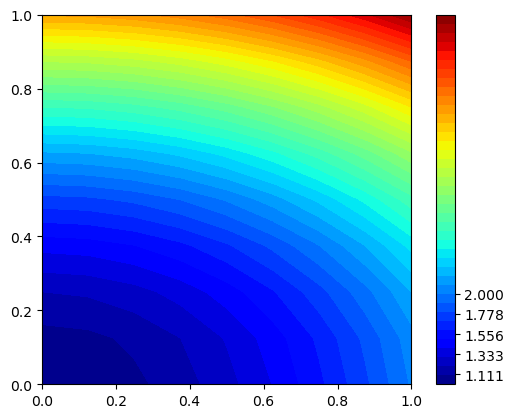

time = 0.02
Max error, t=0.02: 0.000     


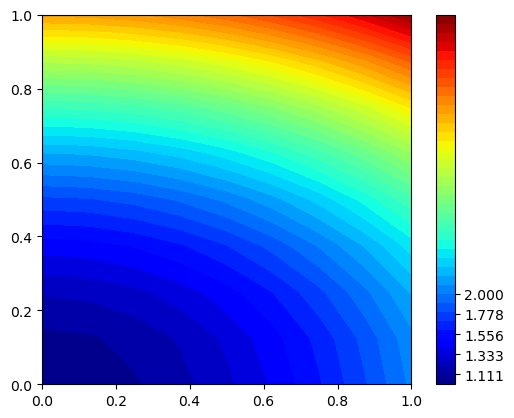

time = 0.03
Max error, t=0.03: 0.000     


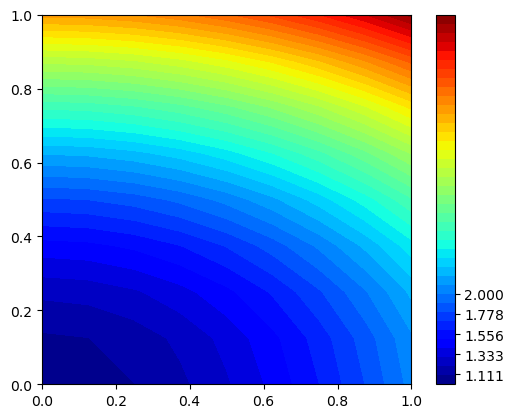

time = 0.04
Max error, t=0.04: 0.000     


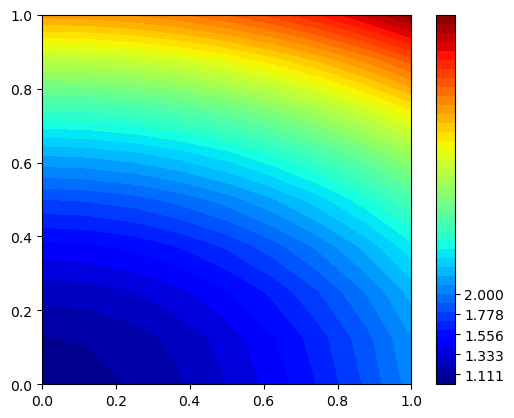

time = 0.05
Max error, t=0.05: 0.000     


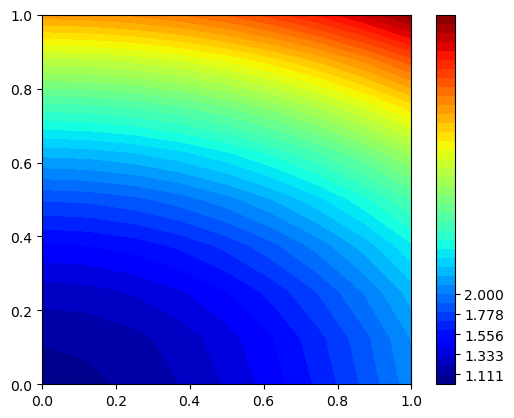

time = 0.060000000000000005
Max error, t=0.06: 0.000     


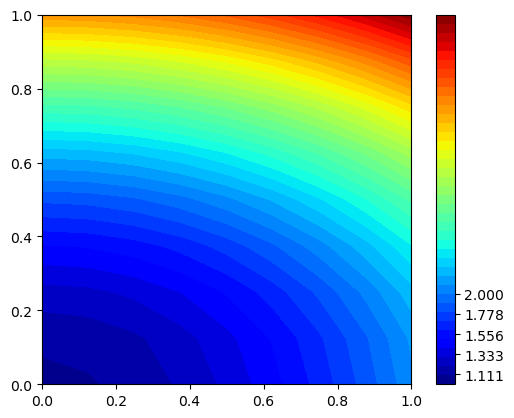

time = 0.07
Max error, t=0.07: 0.000     


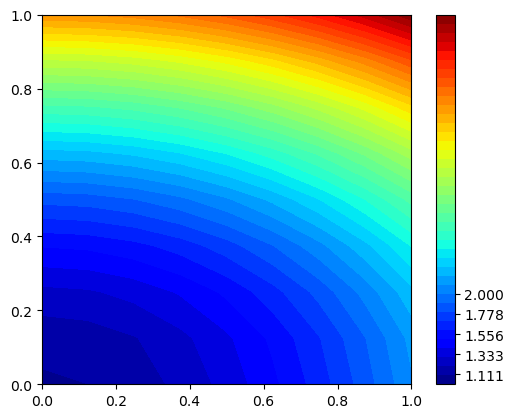

time = 0.08
Max error, t=0.08: 0.000     


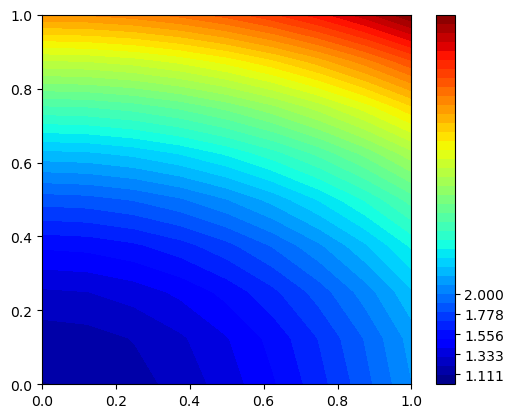

time = 0.09
Max error, t=0.09: 0.000     


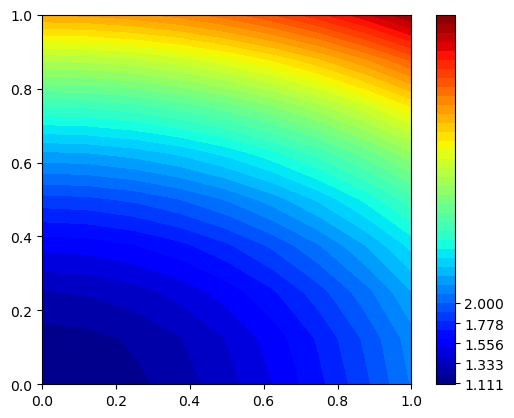

time = 0.09999999999999999
Max error, t=0.10: 0.000     


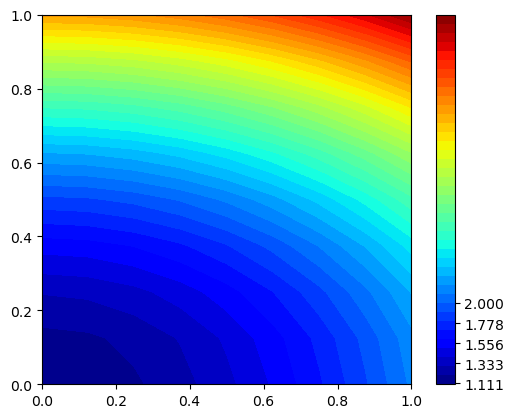

time = 0.10999999999999999
Max error, t=0.11: 0.000     


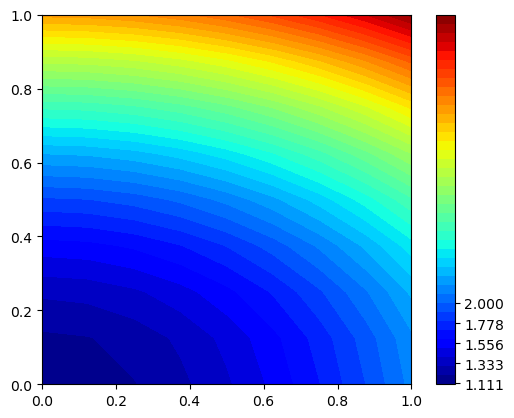

time = 0.11999999999999998
Max error, t=0.12: 0.000     


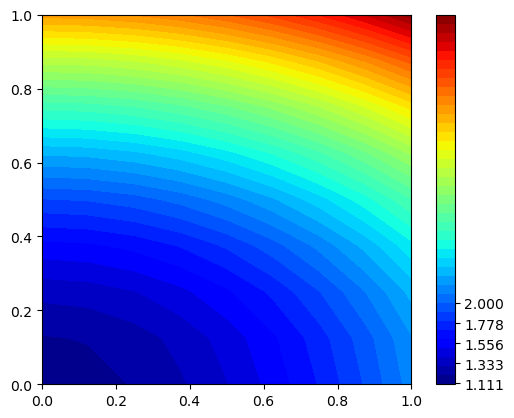

time = 0.12999999999999998
Max error, t=0.13: 0.000     


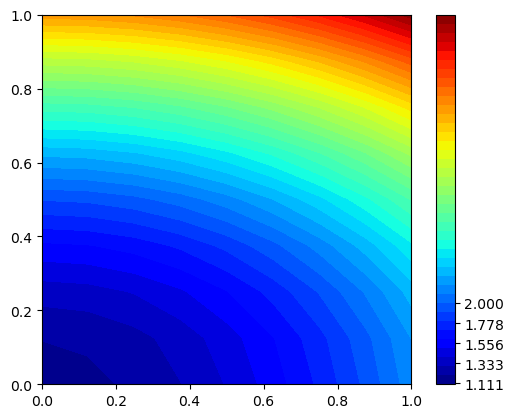

time = 0.13999999999999999
Max error, t=0.14: 0.000     


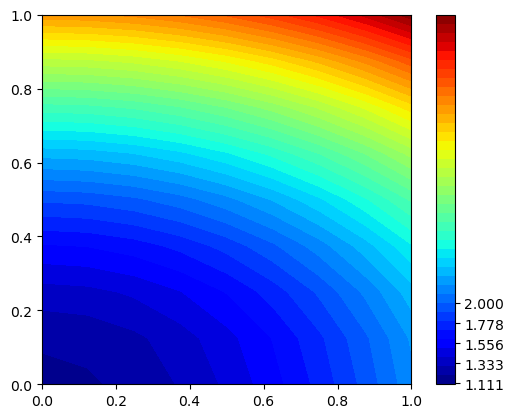

time = 0.15
Max error, t=0.15: 0.000     


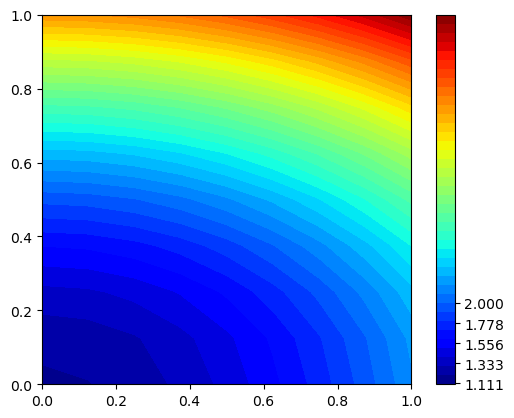

time = 0.16
Max error, t=0.16: 0.000     


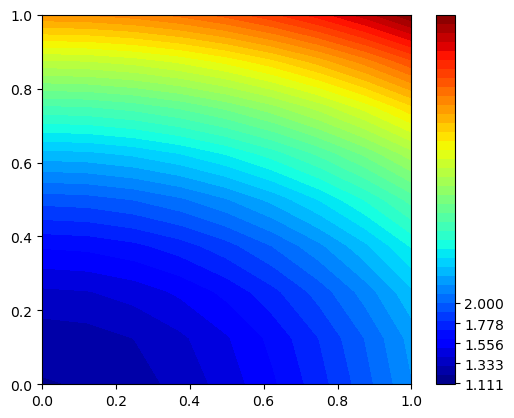

time = 0.17
Max error, t=0.17: 0.000     


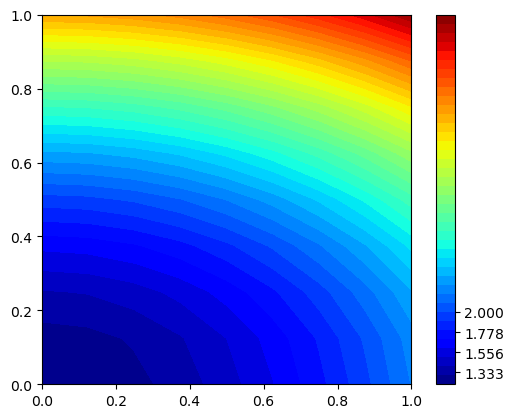

time = 0.18000000000000002
Max error, t=0.18: 0.000     


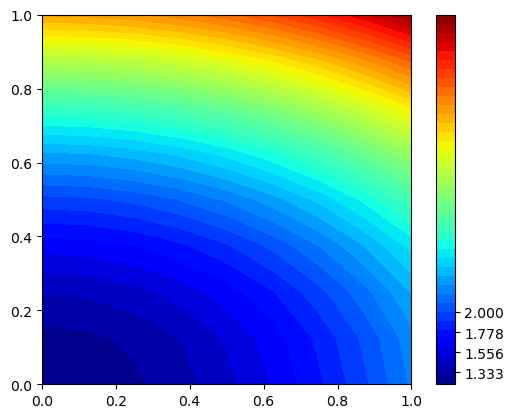

time = 0.19000000000000003
Max error, t=0.19: 0.000     


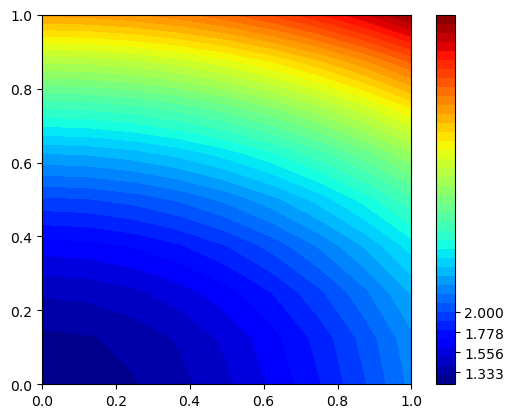

time = 0.20000000000000004
Max error, t=0.20: 0.000     


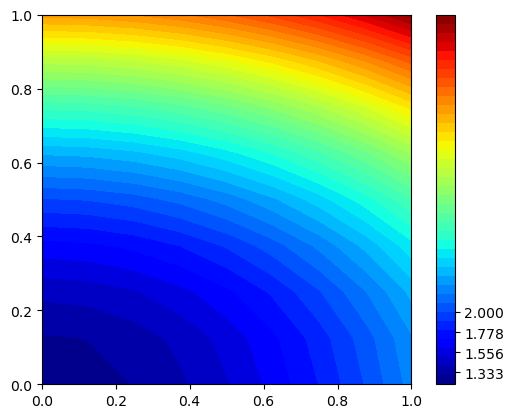

time = 0.21000000000000005
Max error, t=0.21: 0.000     


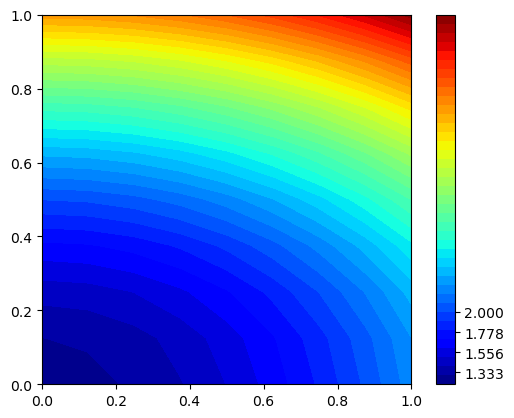

time = 0.22000000000000006
Max error, t=0.22: 0.000     


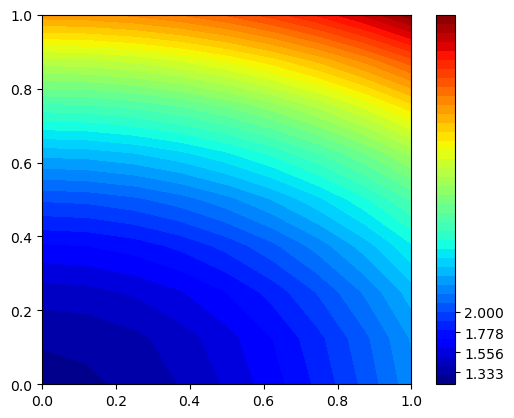

time = 0.23000000000000007
Max error, t=0.23: 0.000     


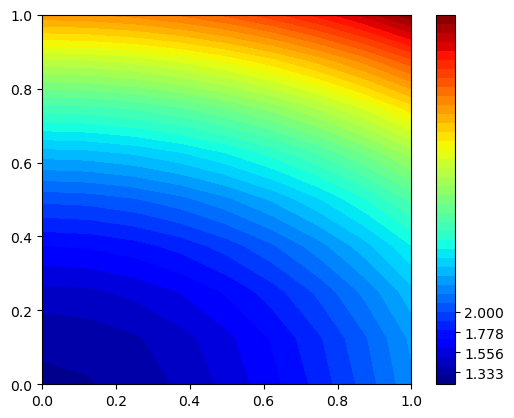

time = 0.24000000000000007
Max error, t=0.24: 0.000     


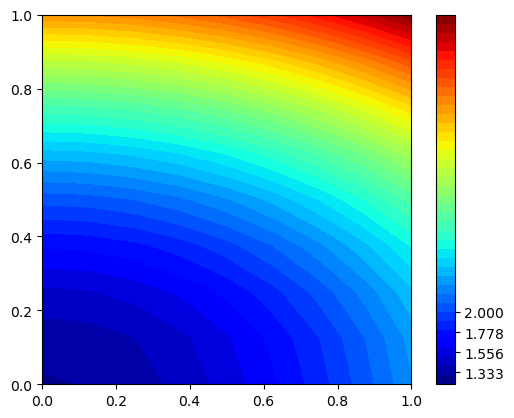

time = 0.25000000000000006
Max error, t=0.25: 0.000     


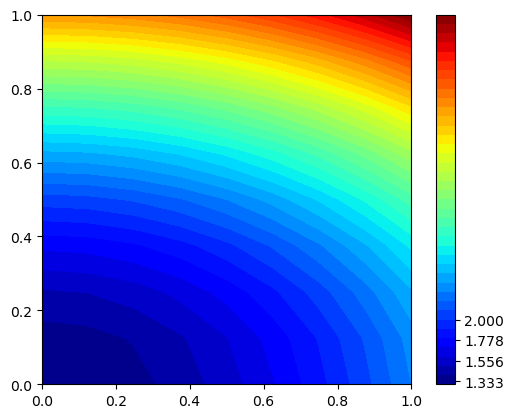

time = 0.26000000000000006
Max error, t=0.26: 0.000     


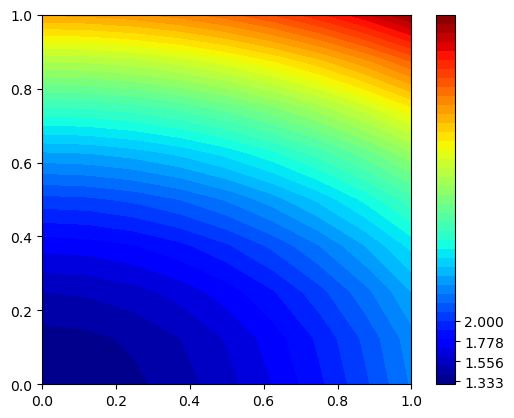

time = 0.2700000000000001
Max error, t=0.27: 0.000     


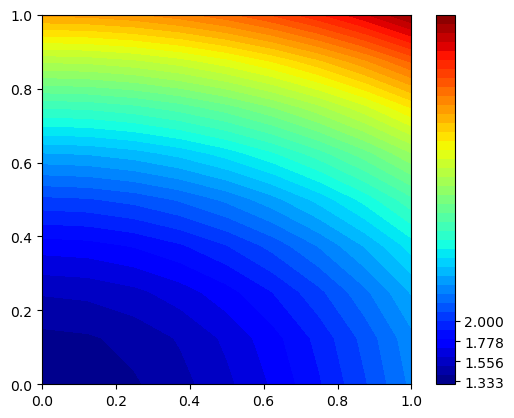

time = 0.2800000000000001
Max error, t=0.28: 0.000     


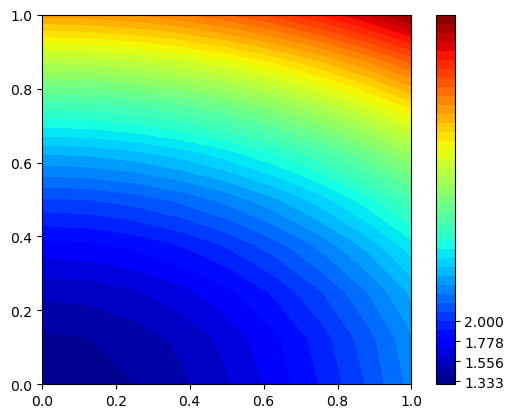

time = 0.2900000000000001
Max error, t=0.29: 0.000     


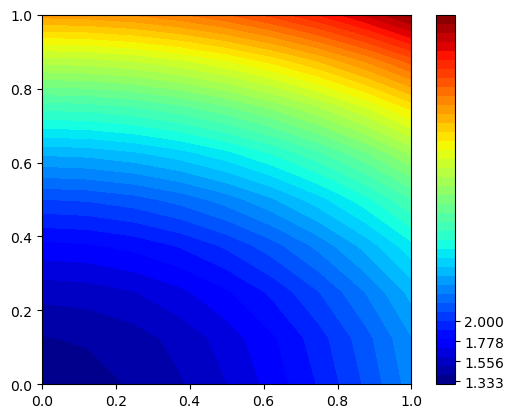

time = 0.3000000000000001
Max error, t=0.30: 0.000     


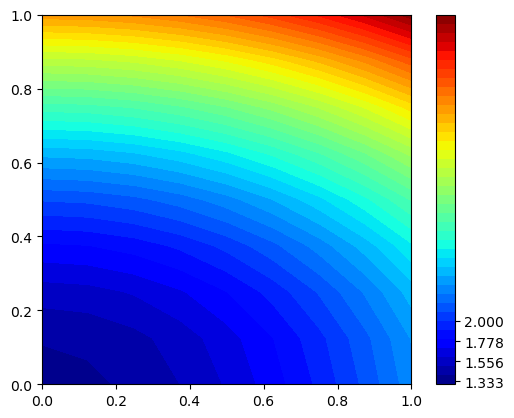

time = 0.3100000000000001
Max error, t=0.31: 0.000     


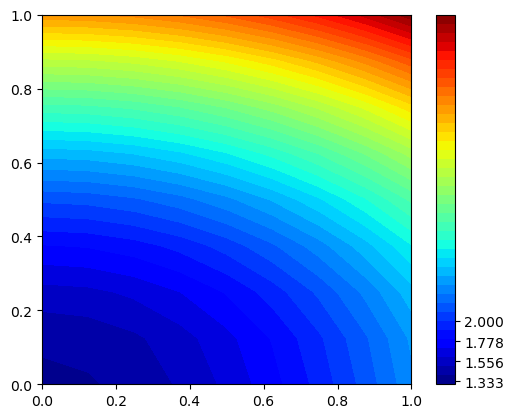

time = 0.3200000000000001
Max error, t=0.32: 0.000     


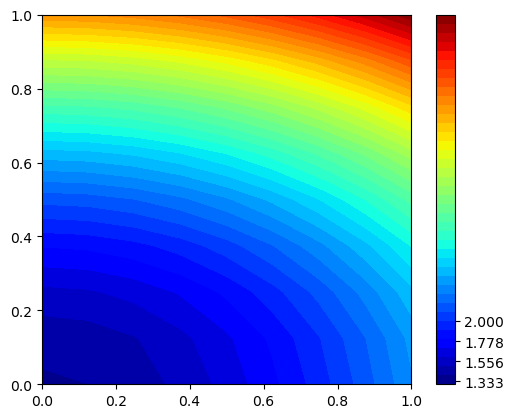

time = 0.3300000000000001
Max error, t=0.33: 0.000     


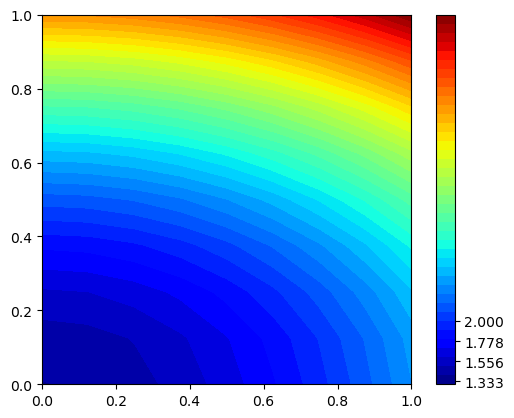

time = 0.34000000000000014
Max error, t=0.34: 0.000     


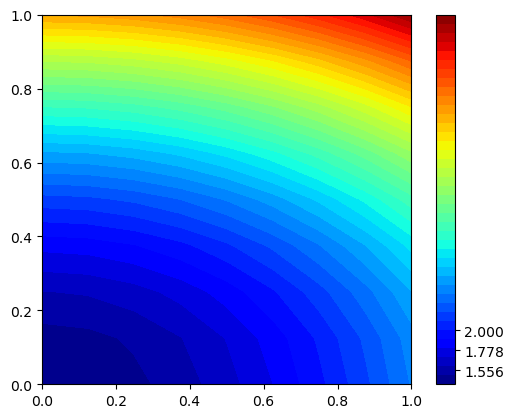

time = 0.35000000000000014
Max error, t=0.35: 0.000     


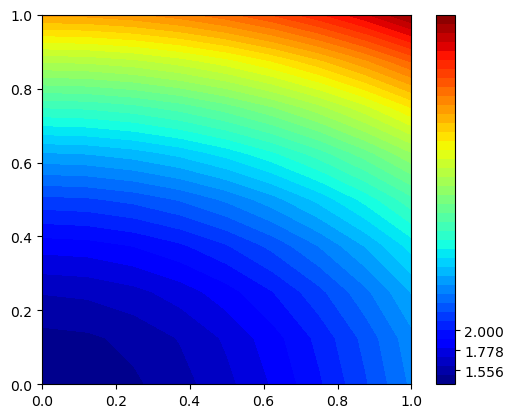

time = 0.36000000000000015
Max error, t=0.36: 0.000     


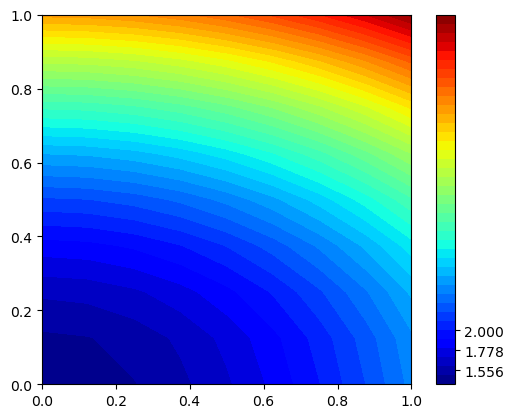

time = 0.37000000000000016
Max error, t=0.37: 0.000     


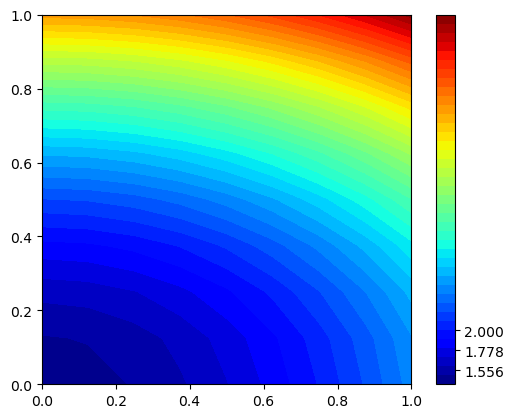

time = 0.38000000000000017
Max error, t=0.38: 0.000     


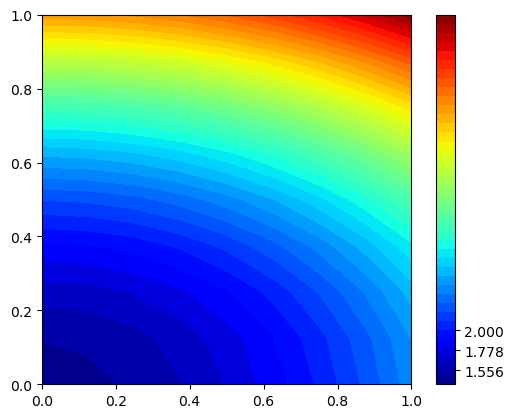

time = 0.3900000000000002
Max error, t=0.39: 0.000     


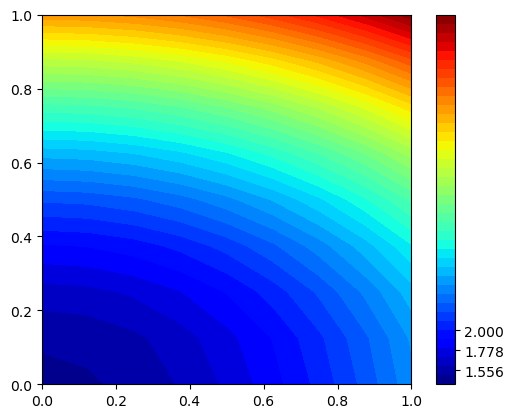

time = 0.4000000000000002
Max error, t=0.40: 0.000     


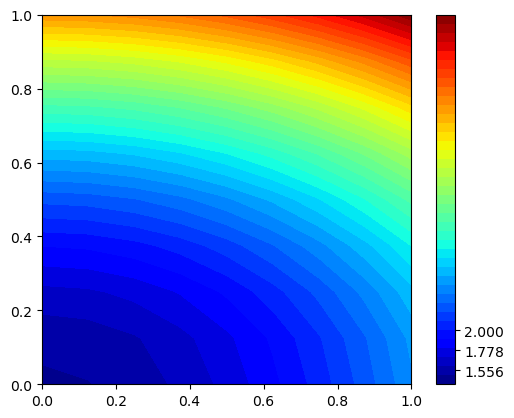

time = 0.4100000000000002
Max error, t=0.41: 0.000     


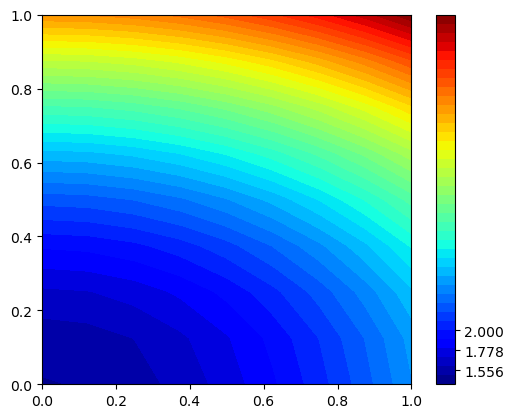

time = 0.4200000000000002
Max error, t=0.42: 0.000     


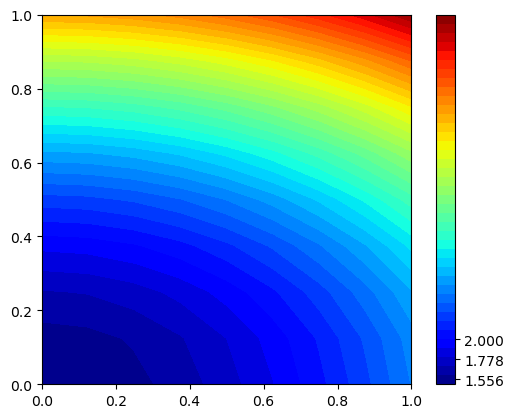

time = 0.4300000000000002
Max error, t=0.43: 0.000     


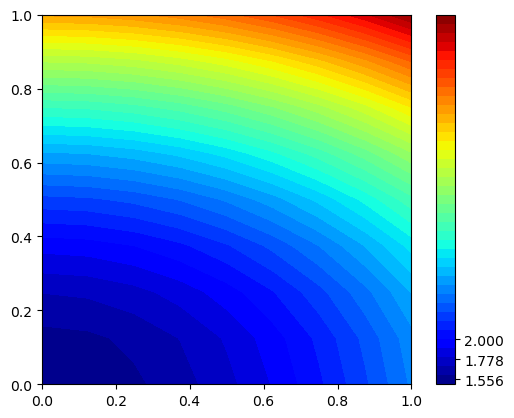

time = 0.4400000000000002
Max error, t=0.44: 0.000     


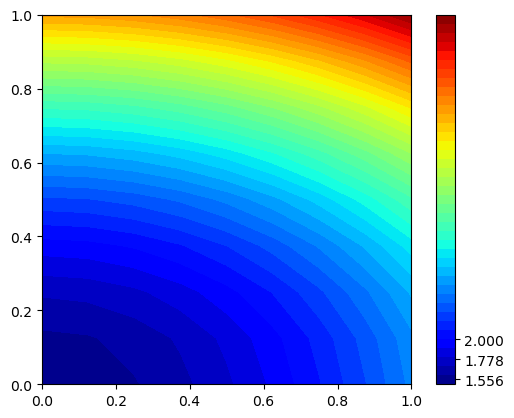

time = 0.45000000000000023
Max error, t=0.45: 0.000     


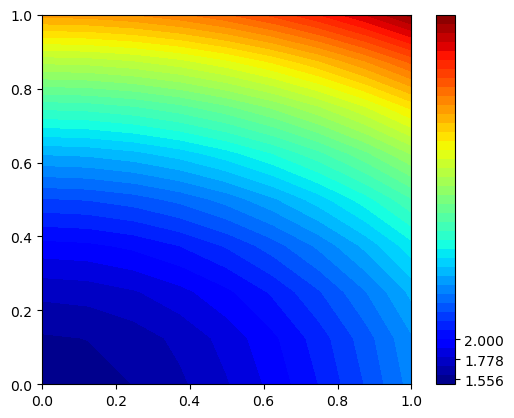

time = 0.46000000000000024
Max error, t=0.46: 0.000     


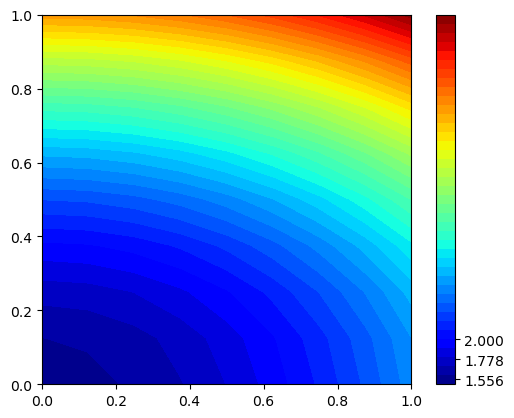

time = 0.47000000000000025
Max error, t=0.47: 0.000     


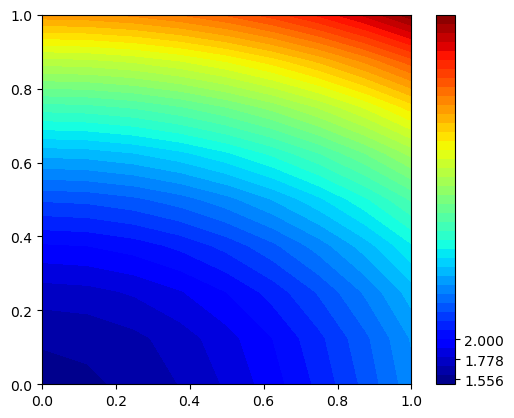

time = 0.48000000000000026
Max error, t=0.48: 0.000     


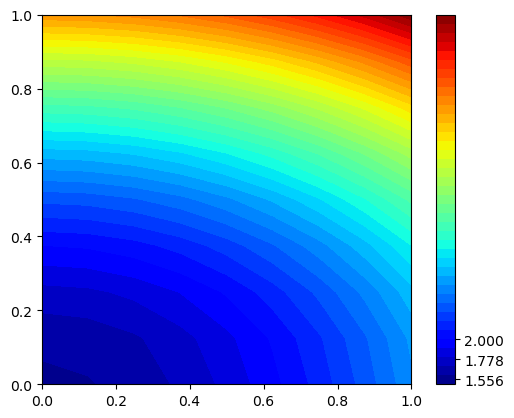

time = 0.49000000000000027
Max error, t=0.49: 0.000     


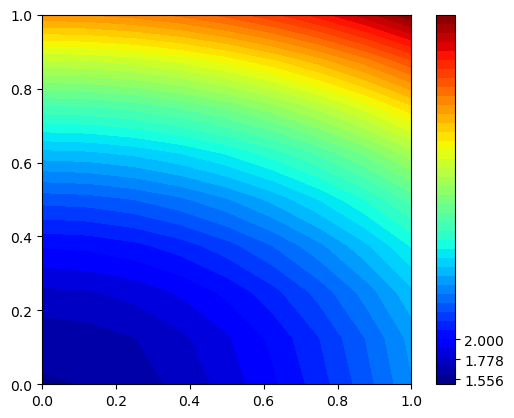

time = 0.5000000000000002
Max error, t=0.50: 0.000     


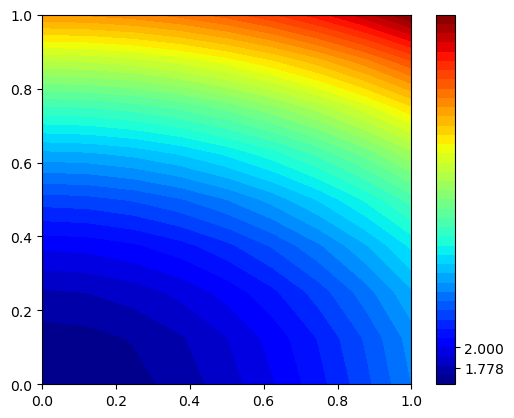

time = 0.5100000000000002
Max error, t=0.51: 0.000     


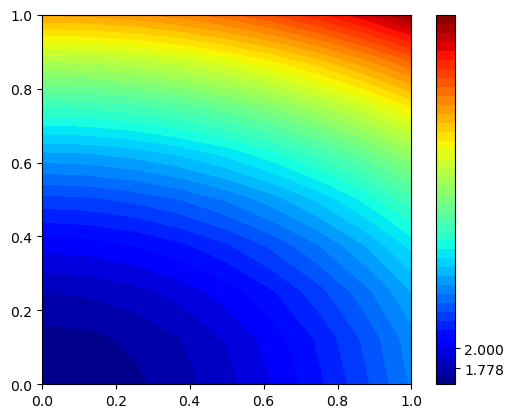

time = 0.5200000000000002
Max error, t=0.52: 0.000     


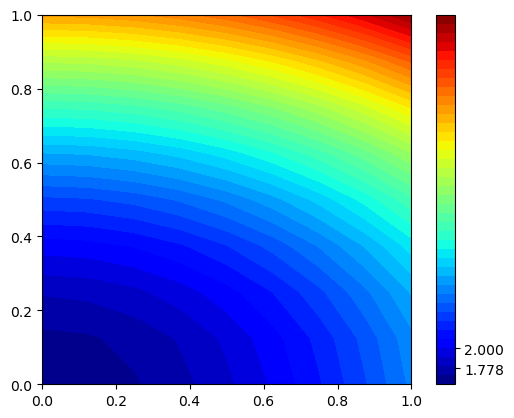

time = 0.5300000000000002
Max error, t=0.53: 0.000     


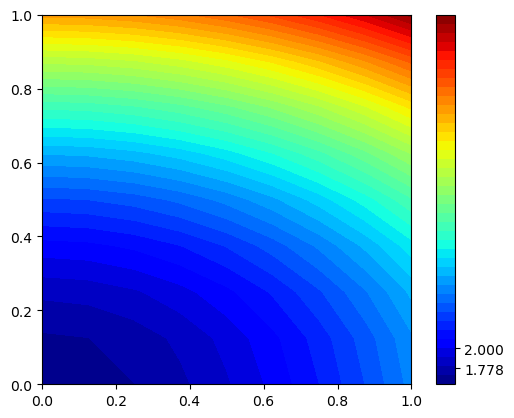

time = 0.5400000000000003
Max error, t=0.54: 0.000     


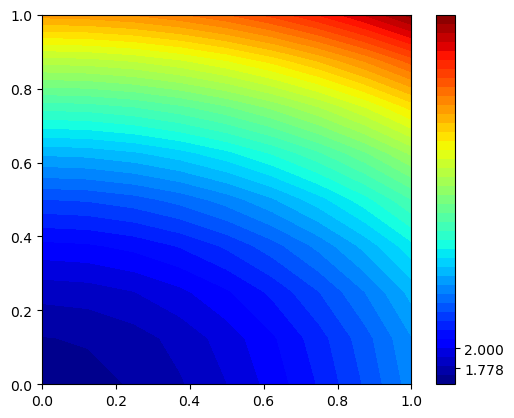

time = 0.5500000000000003
Max error, t=0.55: 0.000     


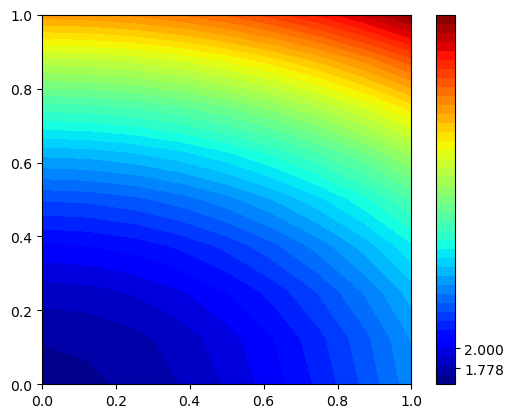

time = 0.5600000000000003
Max error, t=0.56: 0.000     


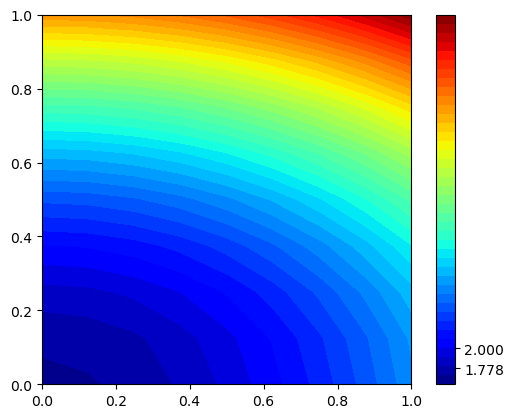

time = 0.5700000000000003
Max error, t=0.57: 0.000     


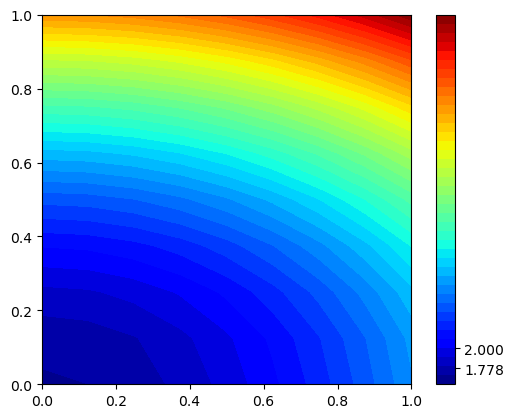

time = 0.5800000000000003
Max error, t=0.58: 0.000     


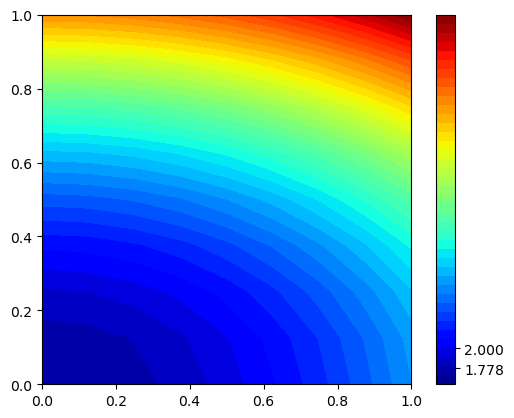

time = 0.5900000000000003
Max error, t=0.59: 0.000     


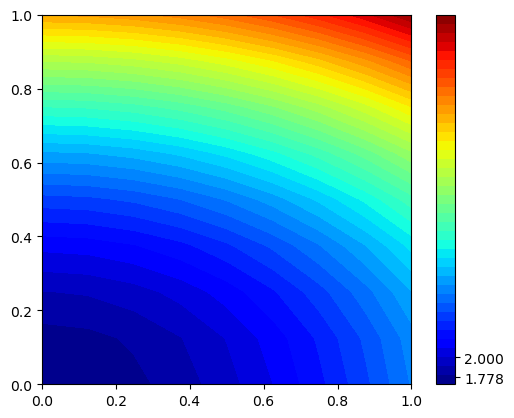

time = 0.6000000000000003
Max error, t=0.60: 0.000     


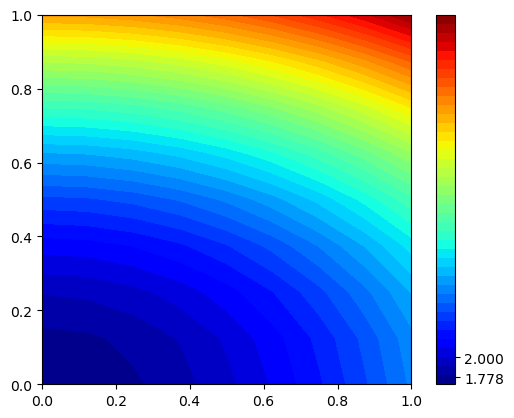

time = 0.6100000000000003
Max error, t=0.61: 0.000     


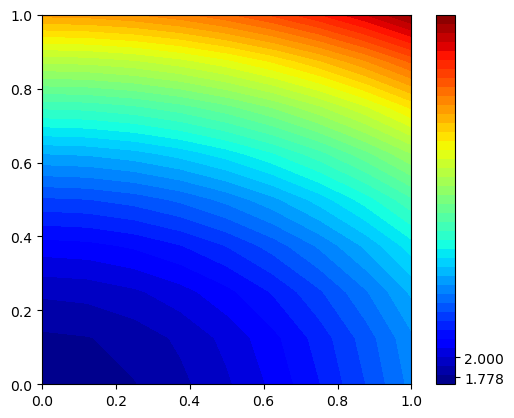

time = 0.6200000000000003
Max error, t=0.62: 0.000     


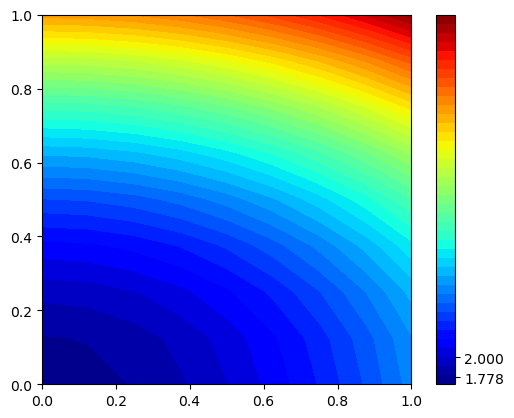

time = 0.6300000000000003
Max error, t=0.63: 0.000     


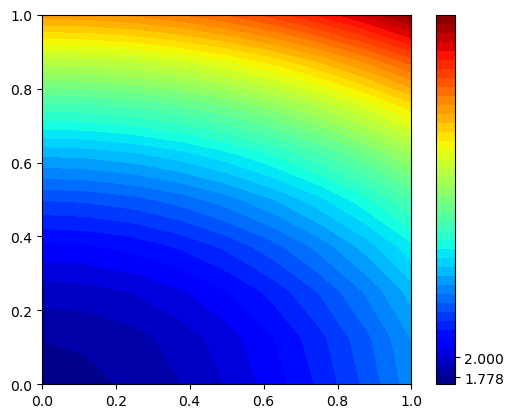

time = 0.6400000000000003
Max error, t=0.64: 0.000     


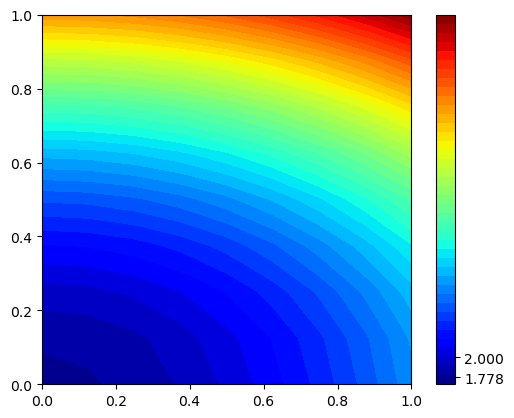

time = 0.6500000000000004
Max error, t=0.65: 0.000     


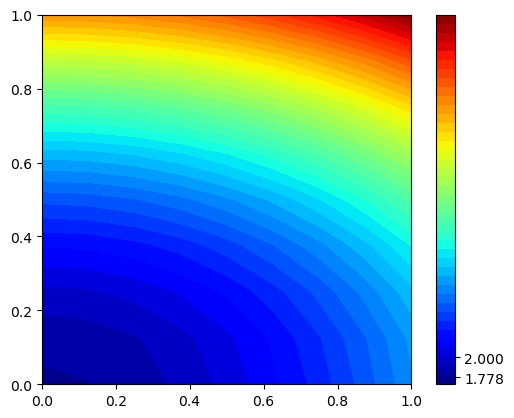

time = 0.6600000000000004
Max error, t=0.66: 0.000     


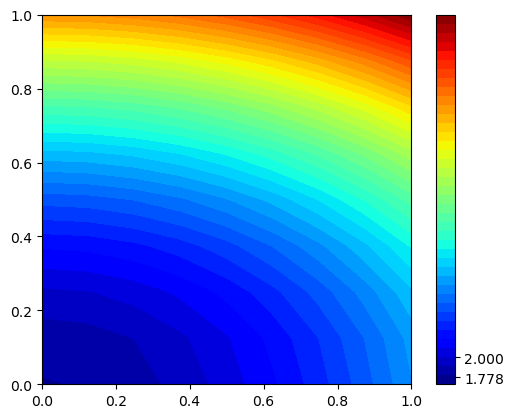

time = 0.6700000000000004
Max error, t=0.67: 0.000     


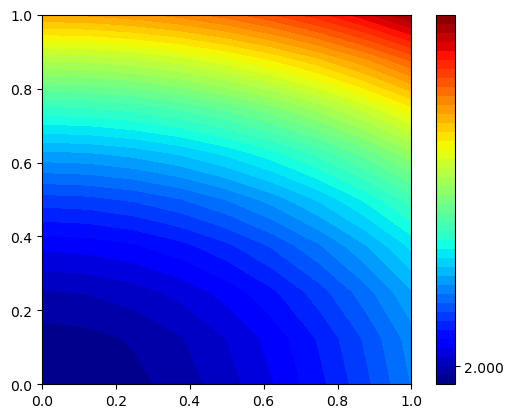

time = 0.6800000000000004
Max error, t=0.68: 0.000     


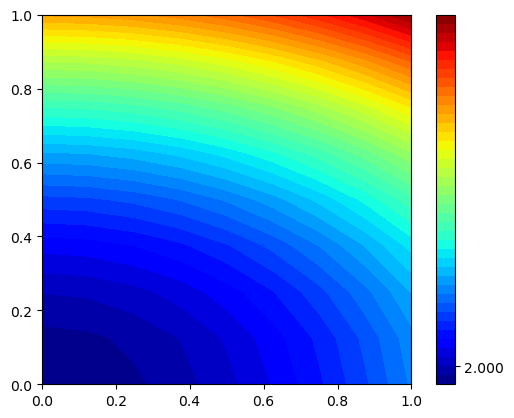

time = 0.6900000000000004
Max error, t=0.69: 0.000     


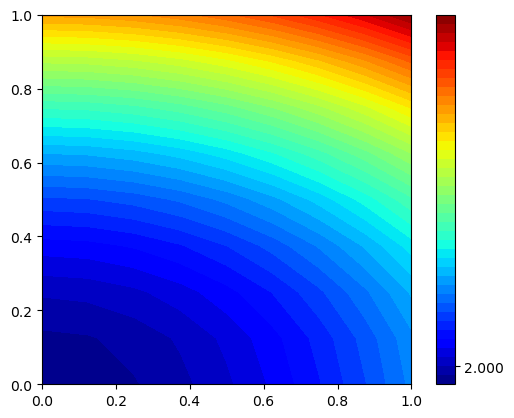

time = 0.7000000000000004
Max error, t=0.70: 0.000     


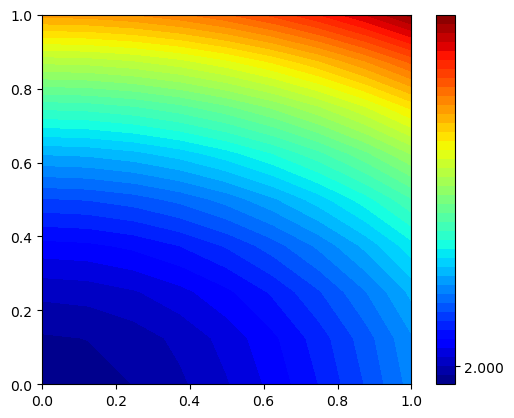

time = 0.7100000000000004
Max error, t=0.71: 0.000     


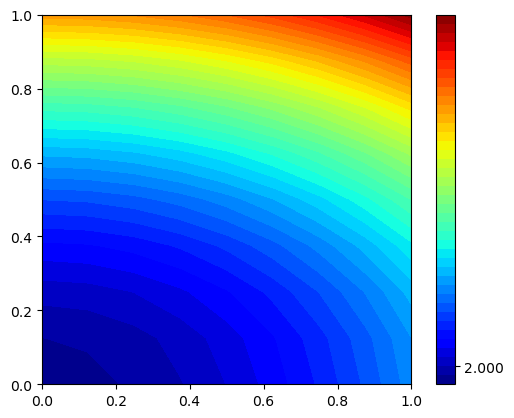

time = 0.7200000000000004
Max error, t=0.72: 0.000     


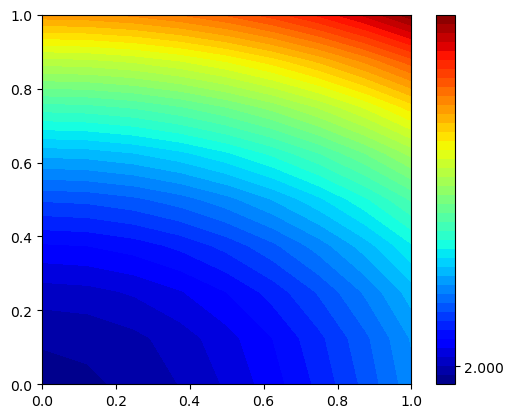

time = 0.7300000000000004
Max error, t=0.73: 0.000     


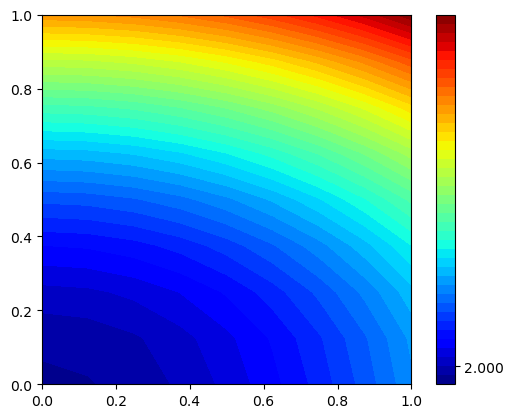

time = 0.7400000000000004
Max error, t=0.74: 0.000     


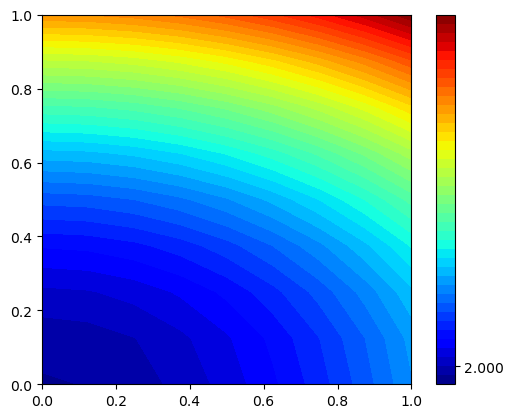

time = 0.7500000000000004
Max error, t=0.75: 0.000     


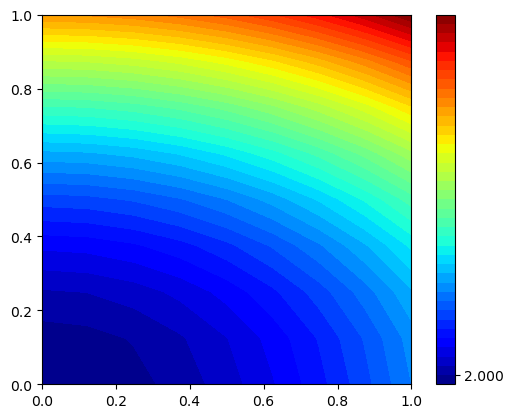

time = 0.7600000000000005
Max error, t=0.76: 0.000     


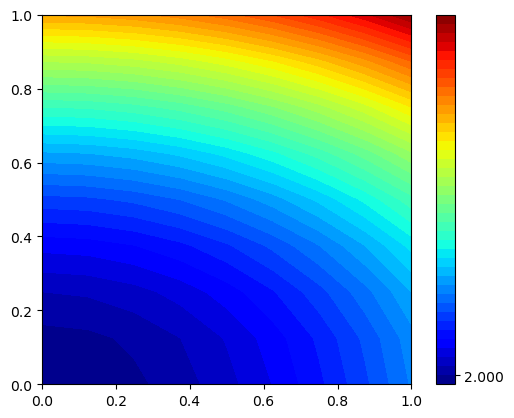

time = 0.7700000000000005
Max error, t=0.77: 0.000     


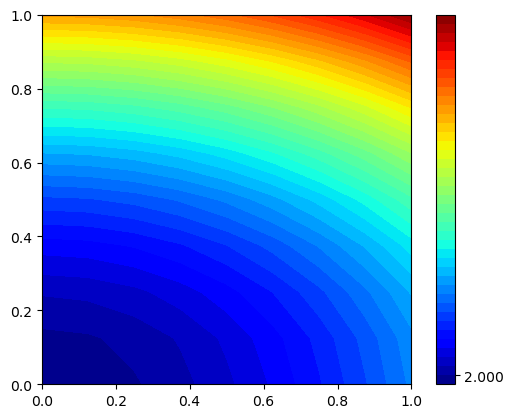

time = 0.7800000000000005
Max error, t=0.78: 0.000     


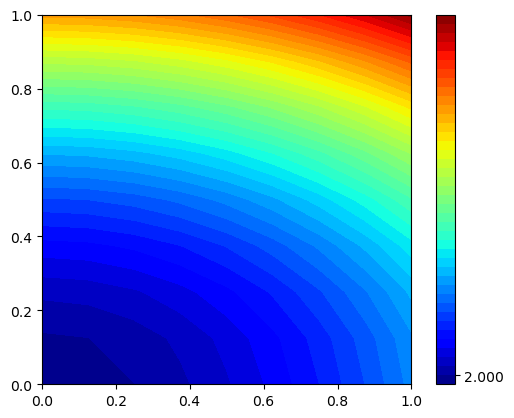

time = 0.7900000000000005
Max error, t=0.79: 0.000     


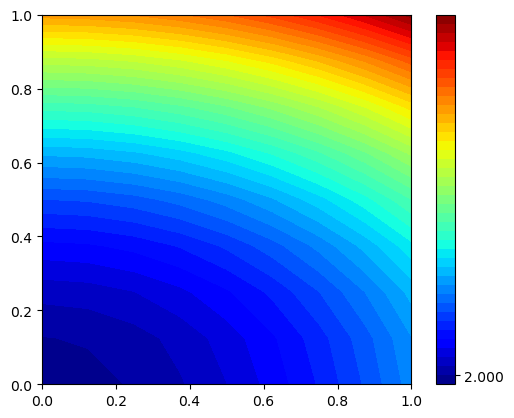

time = 0.8000000000000005
Max error, t=0.80: 0.000     


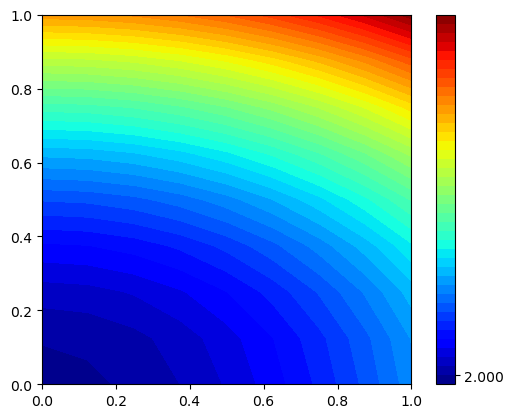

time = 0.8100000000000005
Max error, t=0.81: 0.000     


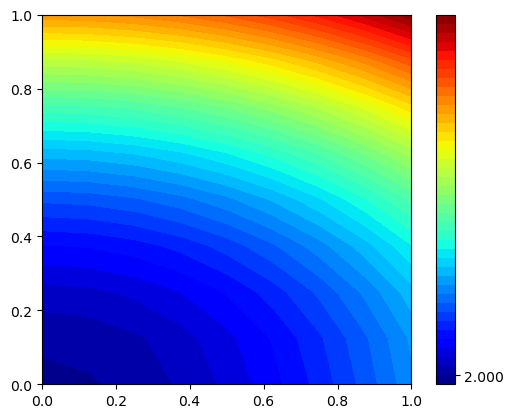

time = 0.8200000000000005
Max error, t=0.82: 0.000     


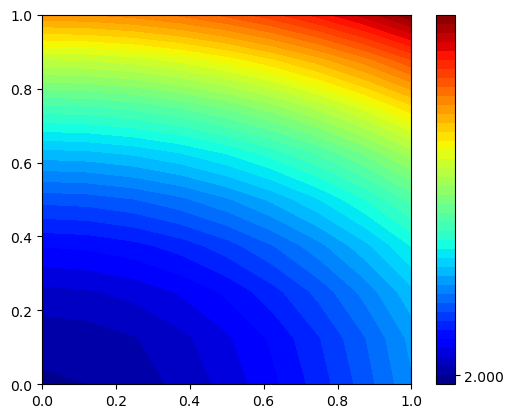

time = 0.8300000000000005
Max error, t=0.83: 0.000     


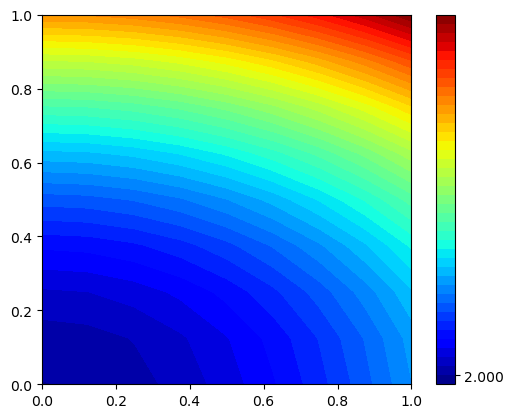

time = 0.8400000000000005
Max error, t=0.84: 0.000     


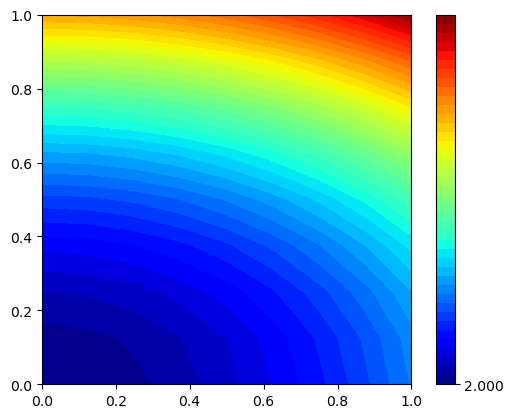

time = 0.8500000000000005
Max error, t=0.85: 0.000     


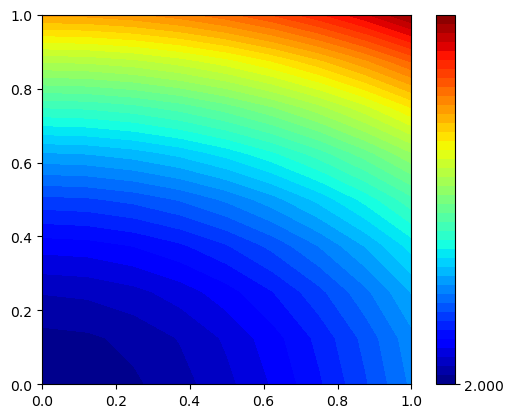

time = 0.8600000000000005
Max error, t=0.86: 0.000     


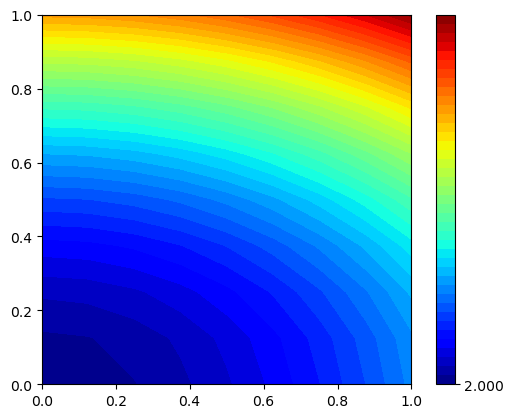

time = 0.8700000000000006
Max error, t=0.87: 0.000     


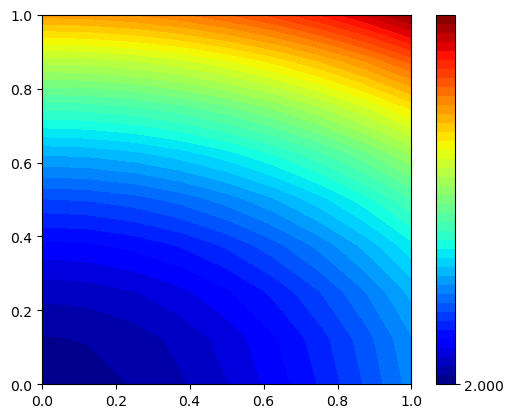

time = 0.8800000000000006
Max error, t=0.88: 0.000     


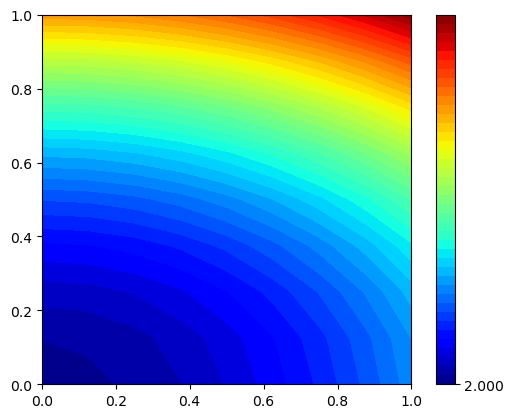

time = 0.8900000000000006
Max error, t=0.89: 0.000     


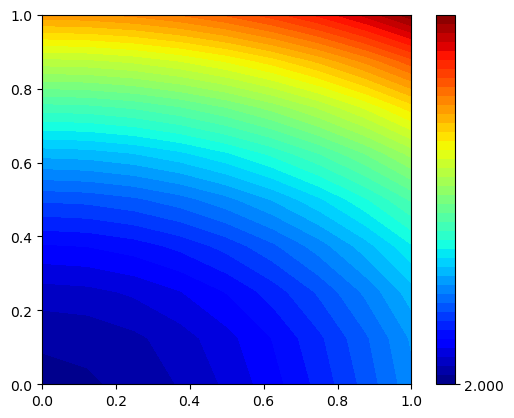

time = 0.9000000000000006
Max error, t=0.90: 0.000     


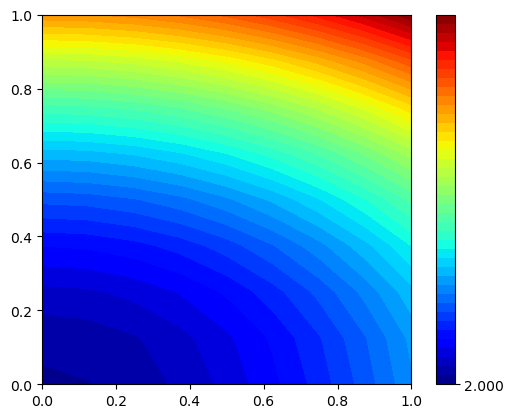

time = 0.9100000000000006
Max error, t=0.91: 0.000     


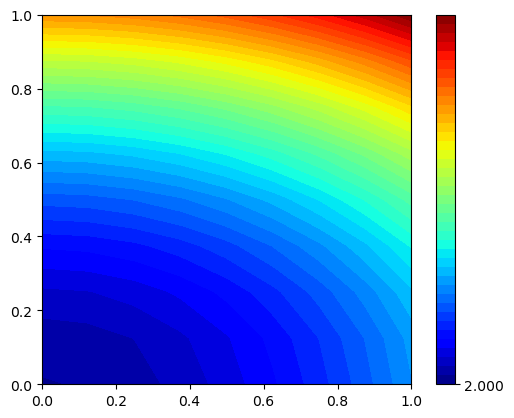

time = 0.9200000000000006
Max error, t=0.92: 0.000     


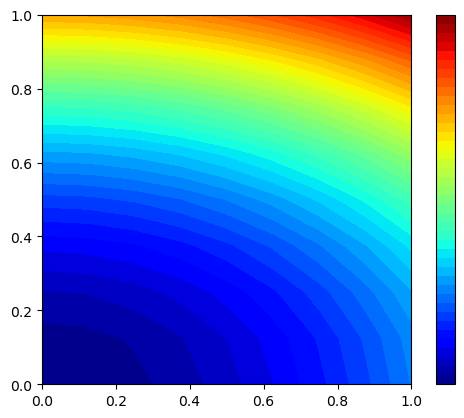

time = 0.9300000000000006
Max error, t=0.93: 0.000     


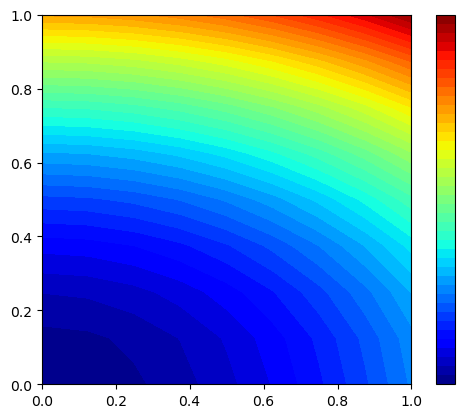

time = 0.9400000000000006
Max error, t=0.94: 0.000     


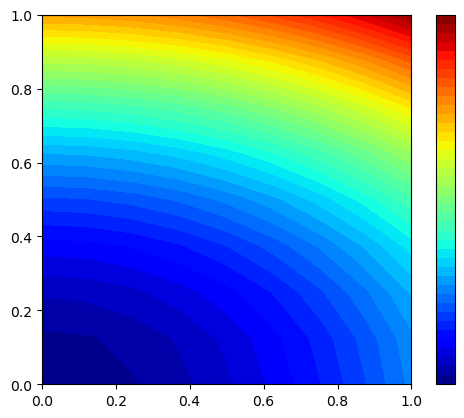

time = 0.9500000000000006
Max error, t=0.95: 0.000     


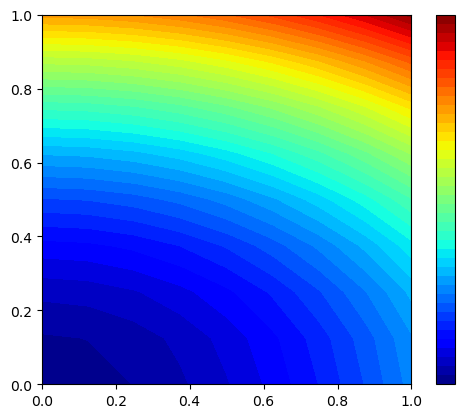

time = 0.9600000000000006
Max error, t=0.96: 0.000     


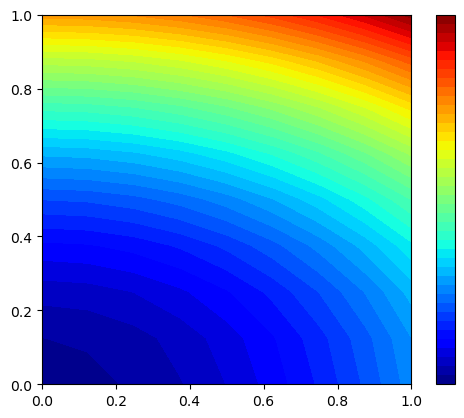

time = 0.9700000000000006
Max error, t=0.97: 0.000     


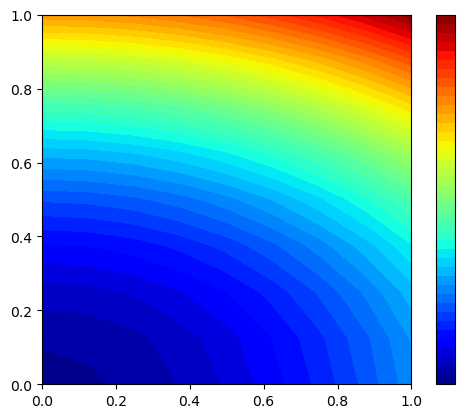

time = 0.9800000000000006
Max error, t=0.98: 0.000     


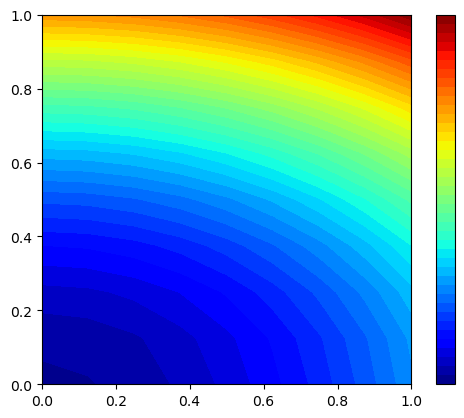

time = 0.9900000000000007
Max error, t=0.99: 0.000     


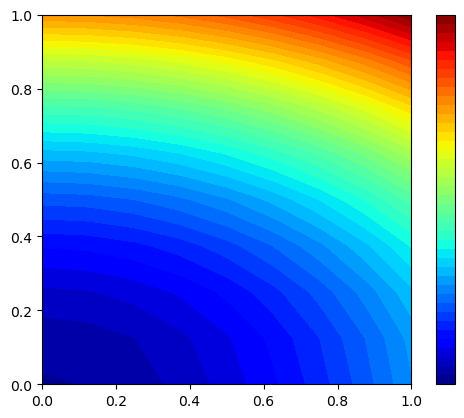

time = 1.0000000000000007
Max error, t=1.00: 0.000     


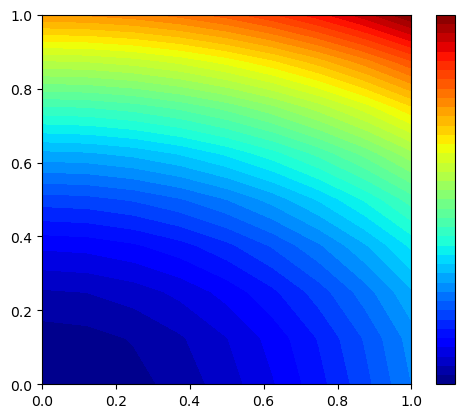

time = 1.0100000000000007
Max error, t=1.01: 0.000     


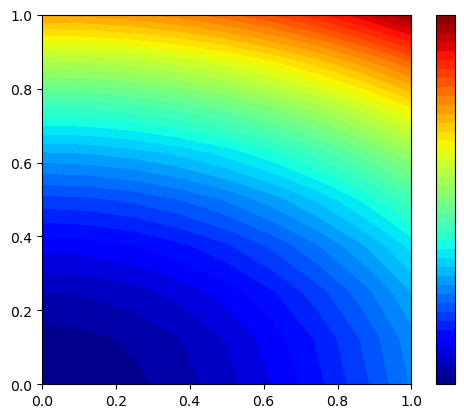

time = 1.0200000000000007
Max error, t=1.02: 0.000     


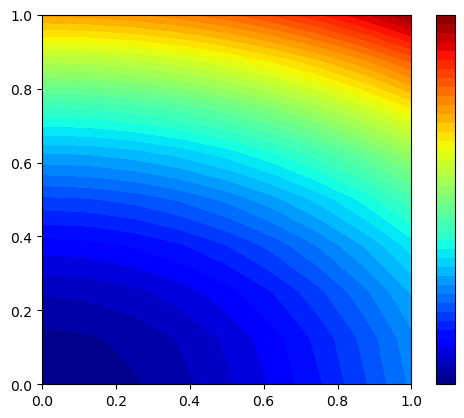

time = 1.0300000000000007
Max error, t=1.03: 0.000     


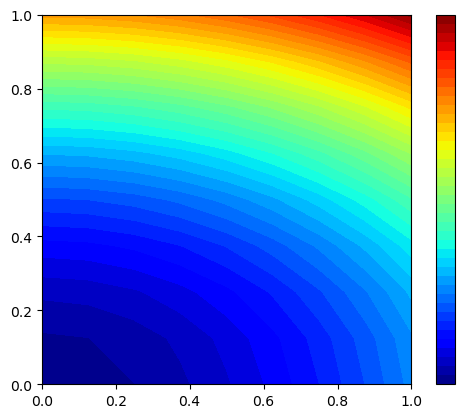

time = 1.0400000000000007
Max error, t=1.04: 0.000     


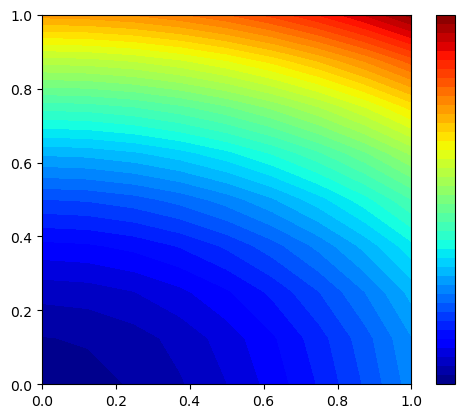

time = 1.0500000000000007
Max error, t=1.05: 0.000     


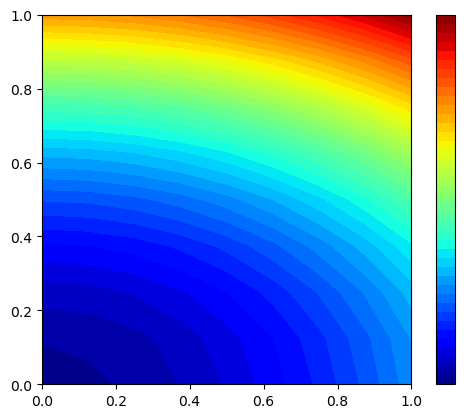

time = 1.0600000000000007
Max error, t=1.06: 0.000     


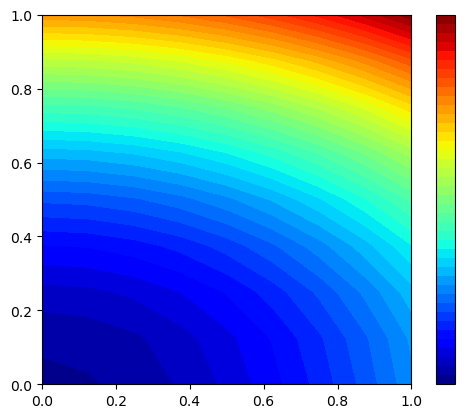

time = 1.0700000000000007
Max error, t=1.07: 0.000     


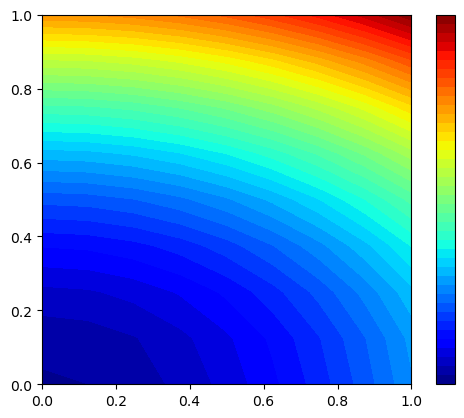

time = 1.0800000000000007
Max error, t=1.08: 0.000     


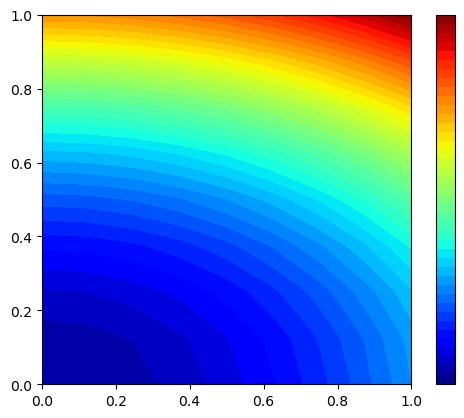

time = 1.0900000000000007
Max error, t=1.09: 0.000     


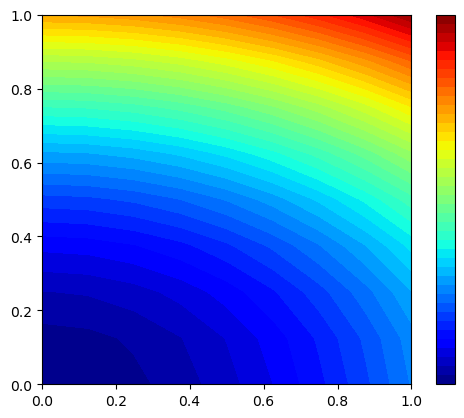

time = 1.1000000000000008
Max error, t=1.10: 0.000     


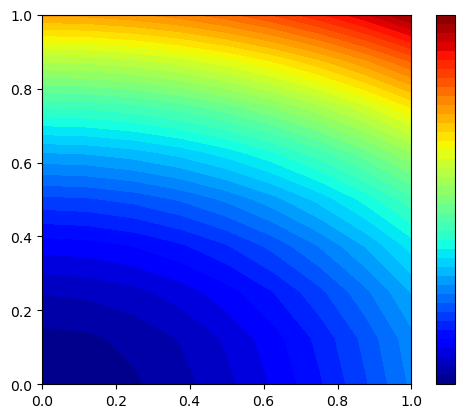

time = 1.1100000000000008
Max error, t=1.11: 0.000     


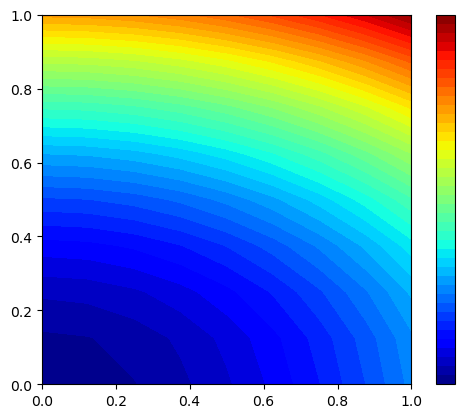

time = 1.1200000000000008
Max error, t=1.12: 0.000     


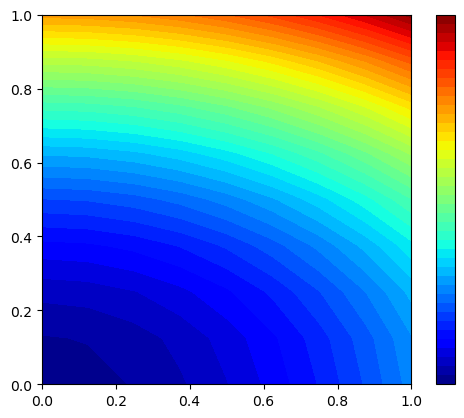

time = 1.1300000000000008
Max error, t=1.13: 0.000     


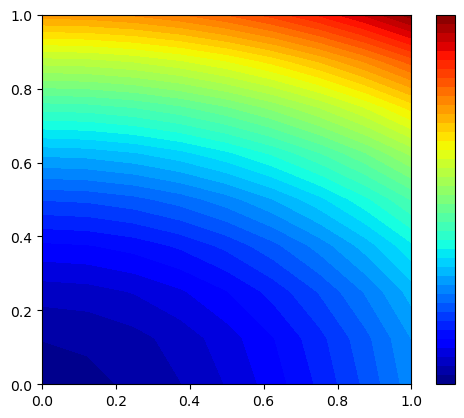

time = 1.1400000000000008
Max error, t=1.14: 0.000     


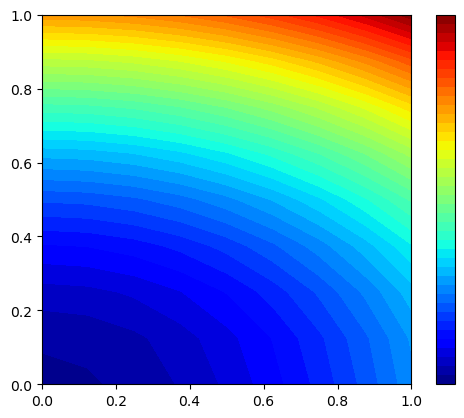

time = 1.1500000000000008
Max error, t=1.15: 0.000     


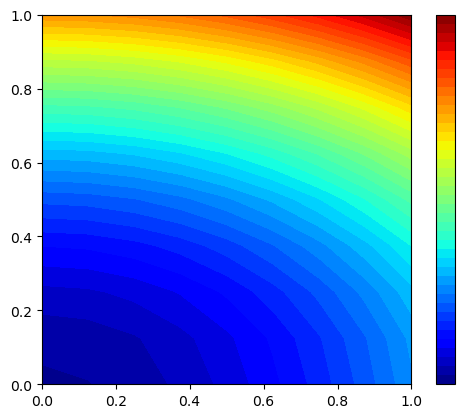

time = 1.1600000000000008
Max error, t=1.16: 0.000     


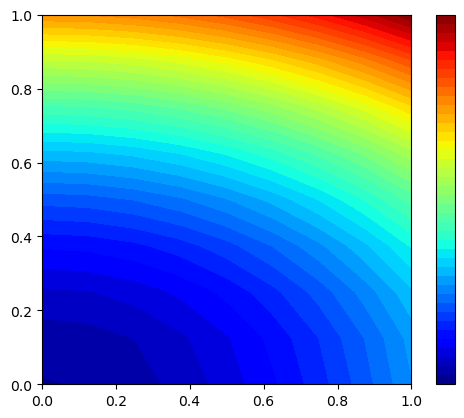

time = 1.1700000000000008
Max error, t=1.17: 0.000     


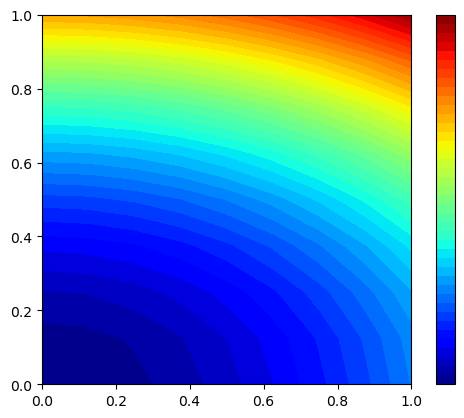

time = 1.1800000000000008
Max error, t=1.18: 0.000     


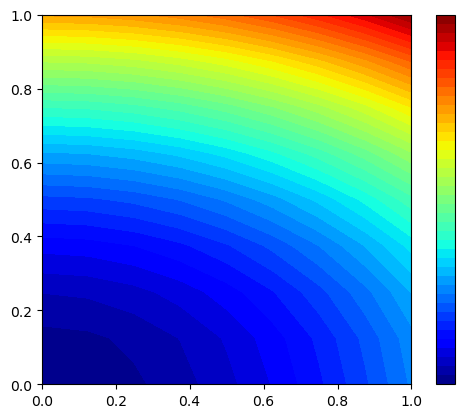

time = 1.1900000000000008
Max error, t=1.19: 0.000     


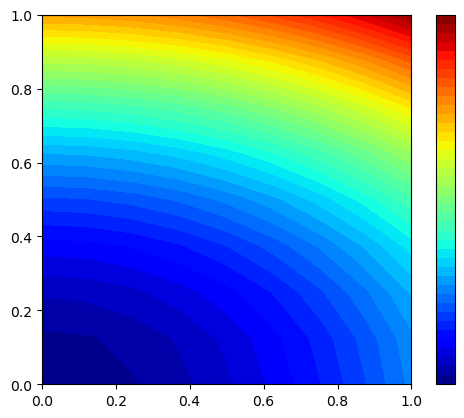

time = 1.2000000000000008
Max error, t=1.20: 0.000     


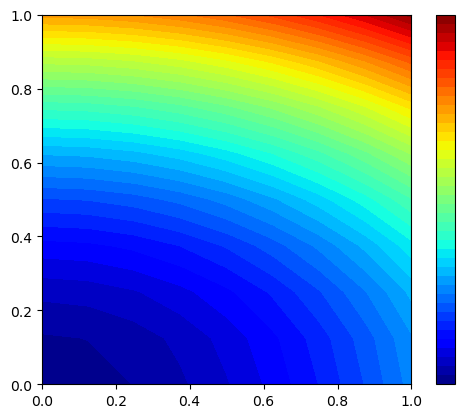

time = 1.2100000000000009
Max error, t=1.21: 0.000     


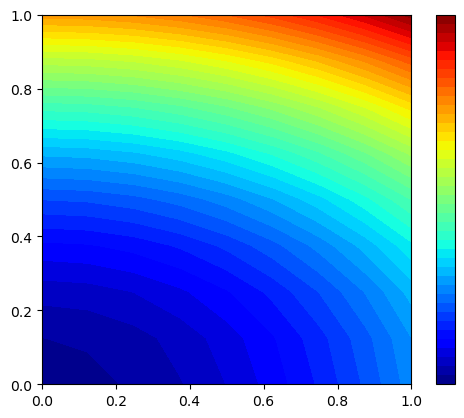

time = 1.2200000000000009
Max error, t=1.22: 0.000     


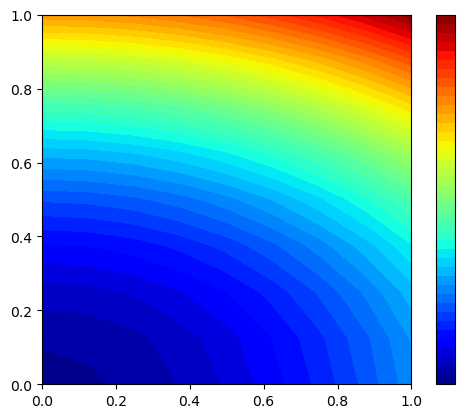

time = 1.2300000000000009
Max error, t=1.23: 0.000     


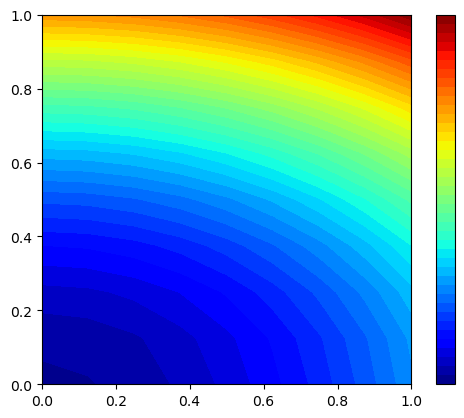

time = 1.2400000000000009
Max error, t=1.24: 0.000     


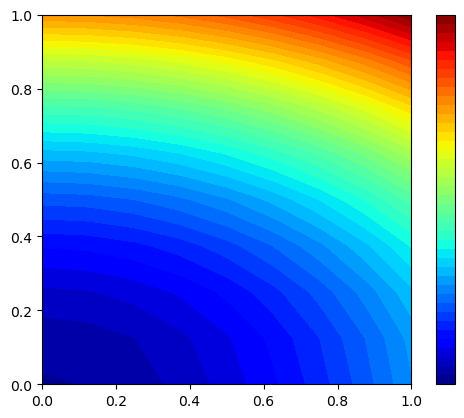

time = 1.2500000000000009
Max error, t=1.25: 0.000     


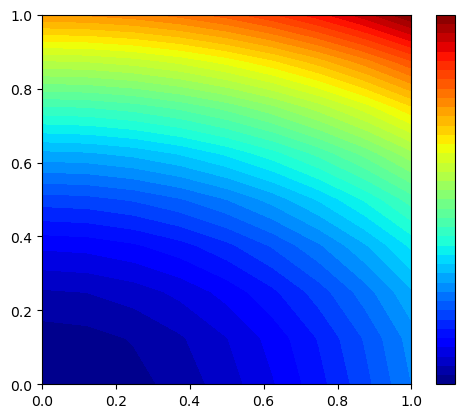

time = 1.260000000000001
Max error, t=1.26: 0.000     


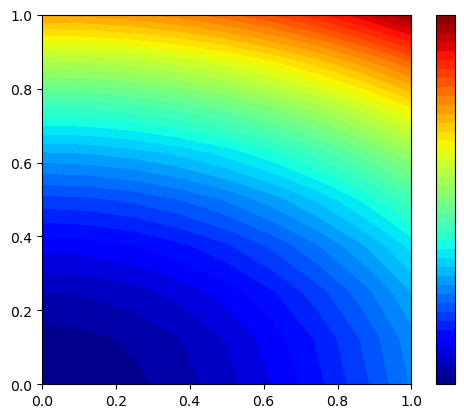

time = 1.270000000000001
Max error, t=1.27: 0.000     


In [ ]:
"""
FEniCS tutorial demo program: Diffusion equation with Dirichlet
conditions and a solution that will be exact at all nodes.
"""

from dolfin import *
import numpy
import matplotlib.pyplot as plt

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'Lagrange', 1)

# Define boundary conditions
alpha = 3; beta = 1.2
u0 = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                alpha=alpha, beta=beta, t=0,degree=1)

class Boundary(SubDomain):  # define the Dirichlet boundary
    def inside(self, x, on_boundary):
        return on_boundary

boundary = Boundary()
bc = DirichletBC(V, u0, boundary)

# Initial condition
u_1 = interpolate(u0, V)
#u_1 = project(u0, V)  # will not result in exact solution!

dt = 0.01     # time step

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)
a = u*v*dx + dt*inner(nabla_grad(u), nabla_grad(v))*dx
L = (u_1 + dt*f)*v*dx

A = assemble(a)   # assemble only once, before the time stepping
b = None          # necessary for memory saving assemeble call

# Compute solution
u = Function(V)   # the unknown at a new time level
T = 1.9           # total simulation time
t = dt
while t <= T:
    print ('time =', t)
    b = assemble(L, tensor=b)
    u0.t = t
    bc.apply(A, b)
    solve(A, u.vector(), b)

    # Verify
    u_e = interpolate(u0, V)
    maxdiff = numpy.linalg.norm(u_e.vector().get_local() - u.vector().get_local())
    print( 'Max error, t=%.2f: %-10.3f' % (t, maxdiff))
    p=plot(u_e)
    p.set_cmap ('jet')
    plt.colorbar(p,ticks=numpy.linspace(0, 2, 10))
    plt.show()
    t += dt
    u_1.assign(u)

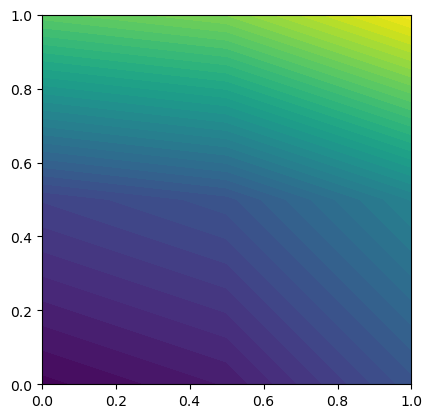